In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
import pylab
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('axes', axisbelow=True)
label_size = 20
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = label_size
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = label_size
pylab.rcParams['xtick.major.pad']=5
pylab.rcParams['ytick.major.pad']=5

lss = ['--',  ':', '-.', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
mss = ['>', 'o',  's', 'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']


In [3]:
mta_data = pd.read_csv('data/MTA_Bridges___Tunnels_Hourly_Traffic_Rates__Beginning_2010_20241012.csv', thousands=',',
                       dtype={
                        'Plaza ID': int,
                        'Hour': int,
                        'Direction': str,
                        '# Vehicles - E-ZPass': int,
                        '# Vehicles - VToll': int
                       }, parse_dates=['Date'])
mta_data['Total Vehicles'] = mta_data['# Vehicles - E-ZPass'] + mta_data['# Vehicles - VToll']

plaza_ids = [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
mta_data = mta_data[mta_data['Plaza ID'].isin(plaza_ids)]

plaza_ids_to_acronyms = {
    21: 'TBX',
    22: 'TBM',
    23: 'BWB',
    24: 'HHB',
    25: 'MPB',
    26: 'CBB',
    27: 'QMT',
    28: 'HCT',
    29: 'TNB',
    30: 'VNB'
}

In [4]:
inbound = mta_data[mta_data['Direction'] == 'I']
inbound['Day of Week'] = inbound['Date'].dt.dayofweek
inbound['Week'] = inbound['Date'].dt.isocalendar().week
inbound['Year'] = inbound['Date'].dt.year
inbound

,Plaza ID,Date,Hour,Direction,# Vehicles - E-ZPass,# Vehicles - VToll,Total Vehicles,Day of Week,Week,Year
0,21,2024-10-05,0,I,2514,597,3111,5,40,2024
1,21,2024-10-05,1,I,1607,414,2021,5,40,2024
2,21,2024-10-05,2,I,1176,332,1508,5,40,2024
3,21,2024-10-05,3,I,1223,324,1547,5,40,2024
4,21,2024-10-05,4,I,1778,453,2231,5,40,2024
...,...,...,...,...,...,...,...,...,...,...
1052337,28,2017-09-03,19,I,820,133,953,6,35,2017
1052339,28,2017-09-03,20,I,751,156,907,6,35,2017
1052341,28,2017-09-03,21,I,595,103,698,6,35,2017
1052343,28,2017-09-03,22,I,556,94,650,6,35,2017


In [5]:
y = inbound['Total Vehicles']
categorical_vars = ['Plaza ID']
numerical_vars = ['Hour', 'Day of Week', 'Week', 'Year']
X = pd.get_dummies(inbound[categorical_vars + numerical_vars], columns=categorical_vars)

In [6]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=50, max_depth=5, n_jobs=-1)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [7]:
inbound['XGBoost Prediction'] = model.predict(X)

In [8]:
# since we are missing hours in some parts, using a dictionary would be the safest option
data_dict = dict()
xgboost_dict = dict()
# keys are ((plaza_id, day of week), (week number, year))
for date in tqdm(pd.date_range(start="2017-09-03", end="2024-10-05")):
    pydatetime = date.to_pydatetime()
    week_number = pydatetime.isocalendar().week
    year = pydatetime.isocalendar().year
    weekday = pydatetime.isocalendar().weekday
    
    data_slice = inbound[(mta_data['Date'] == date) & (mta_data['Direction'] == 'I')]
    
    for plaza_id in plaza_ids:
        if data_slice.empty:
            data_dict[((plaza_id, weekday), (week_number, year))] = None
            xgboost_dict[((plaza_id, weekday), (week_number, year))] = None
            continue
        key = ((plaza_id, weekday), (week_number, year))
        data = data_slice[data_slice['Plaza ID'] == plaza_id ][['Hour', 'Total Vehicles']]
        xgboost_data = data_slice[data_slice['Plaza ID'] == plaza_id ][['Hour', 'XGBoost Prediction']]
        if data.empty:
            data_dict[((plaza_id, weekday), (week_number, year))] = None
            xgboost_dict[((plaza_id, weekday), (week_number, year))] = None
            continue
        data.set_index('Hour', inplace=True)
        xgboost_data.set_index('Hour', inplace=True)
        data_dict[key] = data.reindex(list(range(24))).interpolate()
        xgboost_dict[key] = xgboost_data.reindex(list(range(24))).interpolate()
        
normalized_dict = dict()
for key, value in data_dict.items():
    if value is None:
        normalized_dict[key] = None
        continue
    if len(value) == 0:
        normalized_dict[key] = None
        continue
    normalized_dict[key] = value / value.sum()

100%|██████████| 2590/2590 [01:42<00:00, 25.34it/s]


In [9]:
count = 0
for v in data_dict.values():
    if v is None:
        count += 1
        continue
    if len(v) == 0:
        count += 1
        continue
print(f'Mising Value: {count}, Percent Missing: {count / len(data_dict) * 100}%')

Mising Value: 4616, Percent Missing: 17.822393822393824%


`data_dict` has keys in the form ((plaza id, weekday), (week number, year)). From this, we can build a matrix where the first pairs along the rows and the second pairs along the columns.

We need to test 3 different setups to see which is the best:
1. (normalize, Wasserstein)
2. (normalize, Euclidean)
3. (no normalization, Euclidean)

We cannot use Wasserstein with no normalization because then it is not a distribution.

The matrix size is 70 x (number of weeks * number of years). The 70 comes from (number of days in week * 10 plaza_ids)

In [10]:
from scipy.integrate import quad
from functools import partial
from numpy import quantile

def wasserstein2(inv_cdf1, inv_cdf2):
    """
    Compute the squared 2-Wasserstein metric.
    """
    # Combine the inner part of the integral into one function
    # Estimate integral via quadrature
    y, _ = quad(lambda x : np.power((inv_cdf1(x) - inv_cdf2(x)), 2), 0, 1)
    return y

def wasserstein2_mc(ppf1, ppf2):
    N = 10000
    u = np.random.uniform(0.001,0.999,N)
    return np.sum(np.power(ppf1(u) - ppf2(u), 2)) / N

def discrete_quantile(values, cdf, q):
    # Find the smallest value where the CDF is greater than or equal to the quantile q
    quantile_value = values[np.searchsorted(cdf, q)]
    
    return quantile_value

In [11]:
ppf_dict = dict()
for key, value in data_dict.items():
    if value is None:
        ppf_dict[key] = None
        continue
    if len(value) == 0:
        ppf_dict[key] = None
        continue
    value = value / value.sum()
    cumsum_data = value.cumsum()
    x = cumsum_data.values.flatten()
    y = cumsum_data.index.values
    ppf_dict[key] = (x,y)

In [17]:
from itertools import combinations
import bisect

def step_function(x_points, y_points, x):
    # Find the interval that x falls into
    idx = bisect.bisect_right(x_points, x) - 1
    # If x is before the first point, return the first y
    if idx < 0:
        return y_points[0]
    # If x is beyond the last point, return the last y
    elif idx >= len(y_points):
        return y_points[-1]
    # Otherwise, return the y corresponding to the interval
    return y_points[idx]

def squared_difference_integral(x1, y1, x2, y2):
    # Combine and sort all x points from both arrays, ensuring no duplicates
    x_points = np.unique(np.concatenate((x1, x2)))
    total_integral = 0.0

    for i in range(len(x_points) - 1):
        # Define the interval [x_points[i], x_points[i+1]]
        x_left = x_points[i]
        x_right = x_points[i + 1]
        interval_length = x_right - x_left

        # Find the y-values for this interval
        # Last y-value from each array that is <= x_left
        y1_value = step_function(x1, y1, x_left)
        y2_value = step_function(x2, y2, x_left)

        # Compute squared difference and add to total integral
        squared_difference = (y1_value - y2_value) ** 2
        total_integral += squared_difference * interval_length

    return total_integral

def average_step_function(step_functions):
    # Extract x and y values from each step function
    all_x = np.unique(np.concatenate([sf[0] for sf in step_functions]))
    avg_y = []

    # Loop through each interval
    for i in range(len(all_x) - 1):
        x_left = all_x[i]
        
        # For each step function, get the y-value at the start of this interval
        y_values = []
        for x, y in step_functions:
            y_val = step_function(x, y, x_left)
            y_values.append(y_val)
        # Compute the average y-value for this interval
        avg_y.append(np.mean(y_values))

    # Add the final y-value after the last x-point
    y_values = [y[np.searchsorted(x, all_x[-1], side='right') - 1] for x, y in step_functions]
    avg_y.append(np.mean(y_values))

    return all_x, np.array(avg_y)

def get_wasserstein_dists(ppf_dict, direction = 'user'):
    """Return the pairwise Wasserstein distance for the given row (plaza_id, weekday)
    to all the other rows.

    Args:
        plaza_id (int): ID of bridge or tunnel
        weekday (int): Day of the week (1-7)
        ppf_dict (dict): Dictionary of inverse CDFs

    Returns:
        dict: Dictionary of pairwise Wasserstein distances
    """
    rows = set(k[0] for k in ppf_dict.keys())
    cols = set(k[1] for k in ppf_dict.keys())
    dists = dict()
    
    if direction == 'user':
        row_pairs = list(combinations(rows, 2))
        
        for key1, key2 in tqdm(row_pairs):
            key = frozenset([key1, key2])
            
            if dists.get(key) is None:
                dists[key] = dict()
            
            for c in cols:
                key_row1 = (key1, c)
                key_row2 = (key2, c)
                if ppf_dict.get(key_row1) is None or ppf_dict.get(key_row2) is None:
                    dists[key][c] = None
                    continue
                # dists[key][c] = wasserstein2_mc(ppf_dict[key_row1], ppf_dict[key_row2])
                x1,y1 = ppf_dict[key_row1]
                x2,y2 = ppf_dict[key_row2]
                dists[key][c] = squared_difference_integral(x1, y1, x2, y2)
    elif direction == 'item':
        col_pairs = list(combinations(cols, 2))
        
        for key1, key2 in tqdm(col_pairs):
            key = frozenset([key1, key2])
            
            if dists.get(key) is None:
                dists[key] = dict()
            
            for r in rows:
                key_col1 = (r, key1)
                key_col2 = (r, key2)
                if ppf_dict.get(key_col1) is None or ppf_dict.get(key_col2) is None:
                    dists[key][r] = None
                    continue
                # dists[key][r] = wasserstein2_mc(ppf_dict[key_col1], ppf_dict[key_col2])
                x1,y1 = ppf_dict[key_col1]
                x2,y2 = ppf_dict[key_col2]
                dists[key][r] = squared_difference_integral(x1, y1, x2, y2)
    return dists

In [ ]:
# key = ((24, 2), (36, 2017))
pairwise_dists = get_wasserstein_dists(ppf_dict)

100%|██████████| 2415/2415 [00:28<00:00, 86.01it/s] 


In [18]:
pairwise_dists_wass_item = get_wasserstein_dists(ppf_dict, direction='item')

100%|██████████| 68635/68635 [02:42<00:00, 421.08it/s] 


In [ ]:
with open('pairwise_dists.pkl', 'rb') as f:
    pairwise_dists_old = pickle.load(f)

In [19]:
with open('pairwise_dists_wass_item.pkl', 'wb') as f:
    pickle.dump(pairwise_dists_wass_item, f)

In [ ]:
with open('pairwise_dists.pkl', 'wb') as f:
    pickle.dump(pairwise_dists, f)

In [21]:
def get_neighbors(key, data_dict, dists, dist_threshold, direction='user'):
    (row, col) = key # row is (plaza_id, weekday), col is (week_number, year)
    neighbors = [] # list of neighbors
    if direction == 'user':
        for pair, dist_dict in dists.items(): # iterate over all pairs
            if row not in pair: # if row is not in pair, continue
                continue
            other_row = next(iter(pair - {row})) # get the other row
            if data_dict.get((other_row, col)) is None:
                continue
            dist_sum = 0
            count = 0
            for col2, dist in dist_dict.items(): # iterate over all columns
                if col == col2 or dist is None or np.isnan(dist): # if column is the same or distance is None,
                    continue
                dist_sum += dist # add distance to sum
                count += 1
            if count == 0:
                continue
            # if average distance is less than threshold, add to neighbors
            if (dist_sum / count) < dist_threshold:
                neighbors.append((other_row, col))
    elif direction == 'item':
        for pair, dist_dict in dists.items(): # iterate over all pairs
            if col not in pair: # if row is not in pair, continue
                continue
            other_col = next(iter(pair - {col}))
            if data_dict.get((row, other_col)) is None:
                continue
            dist_sum = 0
            count = 0
            for row2, dist in dist_dict.items():
                if row == row2 or dist is None or np.isnan(dist):
                    continue
                dist_sum += dist
                count += 1
            if count == 0:
                continue
            if (dist_sum / count) < dist_threshold:
                neighbors.append((row, other_col))
    return neighbors

In [39]:
import random

def get_barycenter(ppf_dict, neighbors):
    neighbor_ppfs = [ppf_dict[neighbor_key] for neighbor_key in neighbors if ppf_dict.get(neighbor_key) is not None]
    return average_step_function(neighbor_ppfs)

def get_estimate_discrete_dist(key, ppf_dict, dists, dist_threshold, direction='user'):
    neighbors = get_neighbors(key, ppf_dict, dists, dist_threshold, direction=direction)
    if len(neighbors) == 0:
        return None
    (x_avg, y_avg) = get_barycenter(ppf_dict, neighbors)

    barycenter_cumsum = np.interp(list(range(24)), y_avg, x_avg)
    return [barycenter_cumsum[0]] + np.diff(barycenter_cumsum).tolist()

from hyperopt import hp, tpe, fmin

def evaluate_dist_threshold(key, ppf_dict, dists, dist_threshold, direction='user'):
    neighbors = get_neighbors(key, ppf_dict, dists, dist_threshold, direction=direction)
    if len(neighbors) == 0: # if no neighbors, return high number
        return 100
    (obs_x, obs_y) = ppf_dict[key] # observed ppf
    (est_x, est_y) = get_barycenter(ppf_dict, neighbors) # estimated ppf
    # return wasserstein2(observed_ppf, est_ppf) # return wasserstein distance
    return squared_difference_integral(obs_x, obs_y, est_x, est_y)

def optimize_dist_threshold(key, ppf_dict, dists, num_tests=10, direction='user'):
    keys_to_sample_from = list(set(k for k in ppf_dict.keys() 
                                   if ppf_dict.get(k) is not None # if ppf is not None
                                   and k[0] == key[0] # same row
                                   and k[1] != key[1])) # different column
    rand_keys = random.sample(keys_to_sample_from, num_tests)
    
    def obj(dist_threshold):
        return sum(evaluate_dist_threshold(key=key, 
                                           ppf_dict=ppf_dict, 
                                           dists=dists, 
                                           dist_threshold=dist_threshold,
                                           direction=direction) for key in rand_keys)
    
    best_eta = fmin(fn=obj, verbose = True, space=hp.uniform('eta', 0.0001, 10.0), algo=tpe.suggest, max_evals=50)
    return best_eta['eta']

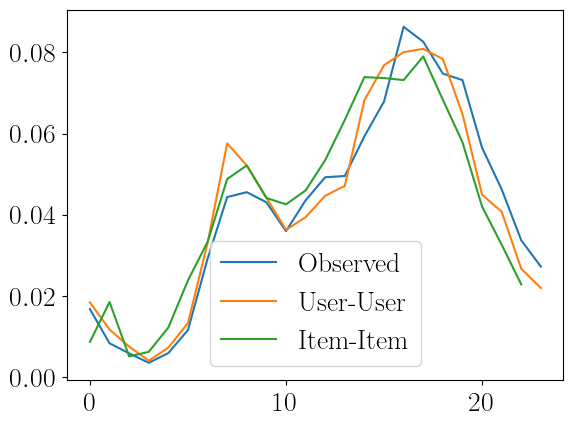

In [37]:
key = ((26, 2), (24, 2019))
plt.plot(range(24), normalized_dict[key].values.flatten(), label='Observed')
plt.plot(range(24), get_estimate_discrete_dist(key, ppf_dict, pairwise_dists, 0.4, direction='user'), label='User-User')
plt.plot(range(24), get_estimate_discrete_dist(key, ppf_dict, pairwise_dists_wass_item, 0.4, direction='item'), label='Item-Item')
plt.legend()
plt.show()

In [767]:
key = ((24, 2), (36, 2017))
dist_threshold = optimize_dist_threshold(key, ppf_dict, pairwise_dists, num_tests=50)

100%|██████████| 50/50 [01:00<00:00,  1.22s/trial, best loss: 11.346179860429558]


In [41]:
key = ((24, 2), (36, 2017))
dist_threshold = optimize_dist_threshold(key, ppf_dict, pairwise_dists_wass_item, num_tests=10, direction='item')

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

 74%|███████▍  | 37/50 [04:20<01:31,  7.04s/trial, best loss: 202.4136889841987]


KeyboardInterrupt: 

In [764]:
# refit xgboost model without the key's data
X = pd.get_dummies(inbound[categorical_vars + numerical_vars], columns=categorical_vars)
X = X[~((inbound['Plaza ID'] == key[0][0]) & (inbound['Day of Week'] == key[0][1]) & (inbound['Week'] == key[1][0]) & (inbound['Year'] == key[1][1]))]
y = inbound['Total Vehicles'][~((inbound['Plaza ID'] == key[0][0]) & (inbound['Day of Week'] == key[0][1]) & (inbound['Week'] == key[1][0]) & (inbound['Year'] == key[1][1]))]

model = XGBRegressor(n_estimators=100, max_depth=10, n_jobs=-1)
model.fit(X, y)
new_data = pd.DataFrame.from_dict({"Hour": list(range(24)), "Day of Week": [weekday] * 24, "Week": [week_number] * 24, "Year": [year] * 24, "Plaza ID": [plaza_id] * 24})
# Convert to same format as original features
new_data = pd.get_dummies(new_data, columns=["Plaza ID"]).reindex(columns = X.columns, fill_value=False)
xgboost_pred = model.predict(new_data)

Distance Threshold: 0.7661862948564898
Number of neighbors: 3


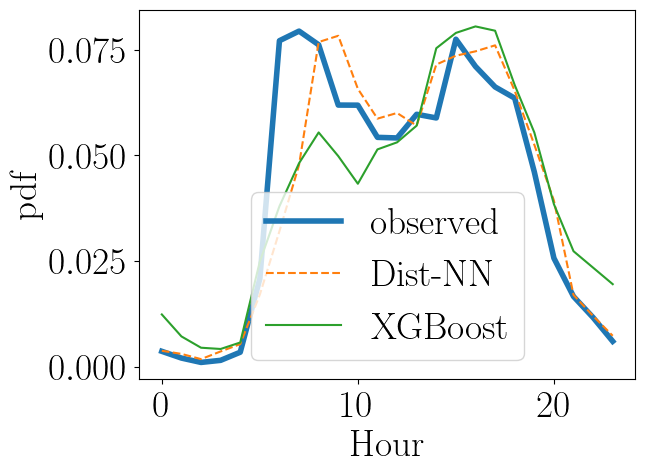

In [768]:
print(f'Distance Threshold: {dist_threshold}')
neighbors = get_neighbors(key, ppf_dict, pairwise_dists, dist_threshold)
print(f'Number of neighbors: {len(neighbors)}')
plt.figure()
plt.plot(range(24), (data_dict[key] / data_dict[key].sum()).values, label='observed', linewidth=4)
est_dist = get_estimate_discrete_dist(key, ppf_dict, pairwise_dists, dist_threshold)
plt.plot(range(24), est_dist, label='Dist-NN', linestyle='--')
ax = plt.gca()
# for neighbor in neighbors:
#     normalized_dict.get((neighbor, key[1])).plot(ax=ax)
plt.plot(list(range(24)), (xgboost_pred / np.sum(xgboost_pred)), label='XGBoost')
plt.xlabel('Hour')
plt.ylabel('pdf')
plt.legend()
plt.show()

#### 2. (normalize, Euclidean)

In [57]:
def get_euclidean_dists(normalized_dict):
    """Return the pairwise Euclidean distance for the given row (plaza_id, weekday)
    to all the other rows.

    Args:
        plaza_id (int): ID of bridge or tunnel
        weekday (int): Day of the week (1-7)
        ppf_dict (dict): Dictionary of inverse CDFs

    Returns:
        dict: Dictionary of pairwise Wasserstein distances
    """
    rows = set(k[0] for k in ppf_dict.keys())
    row_pairs = list(combinations(rows, 2))
    cols = set(k[1] for k in ppf_dict.keys())
    
    dists = dict()
    
    for key1, key2 in tqdm(row_pairs):
        key = frozenset([key1, key2])
        
        if dists.get(key) is None:
            dists[key] = dict()
        
        for c in cols:
            key_row1 = (key1, c)
            key_row2 = (key2, c)
            if normalized_dict.get(key_row1) is None or normalized_dict.get(key_row2) is None:
                dists[key][c] = None
                continue
            dists[key][c] = np.sum(np.power(normalized_dict.get(key_row1).to_numpy() - normalized_dict.get(key_row2).to_numpy(), 2))
    return dists

normalized_euclidean_dists = get_euclidean_dists(normalized_dict)

100%|██████████| 2415/2415 [00:03<00:00, 770.45it/s]


In [ ]:
with open('pairwise_normalized_euclidean_dists.pkl', 'wb') as f:
    pickle.dump(normalized_euclidean_dists, f)

100%|██████████| 50/50 [00:03<00:00, 14.15trial/s, best loss: 0.00023486924534819363]
Distance Threshold: 0.0022108846876865667
Number of neighbors (including self): 3


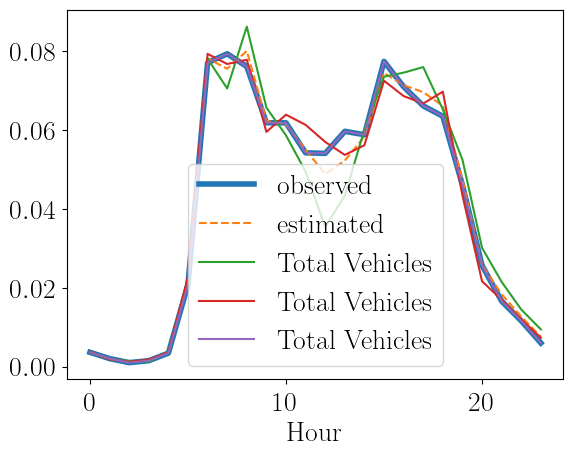

In [58]:
def get_euclidean_avg(key, input_dict, neighbors):
    neighbor_data = np.array([input_dict[(neighbor, key[1])].values for neighbor in neighbors if normalized_dict.get((neighbor, key[1])) is not None])
    return np.mean(neighbor_data, axis=0).flatten()

def evaluate_dist_threshold_euclidean(key, input_dict, euclidean_dists, dist_threshold):
    neighbors = get_neighbors(key, normalized_dict, euclidean_dists, dist_threshold)
    if len(neighbors) == 0: # if no neighbors, return high number
        return np.inf
    observed_data = input_dict.get(key).values # observed
    est = get_euclidean_avg(key, input_dict, neighbors) # estimated
    return np.mean(np.power(observed_data.flatten() - est, 2)) # return squared Euclidean distance

def optimize_dist_threshold_euclidean(key, input_dict, euclidean_dists, max_threshold = 0.1, min_threshold=1e-6, num_tests=10):
    keys_to_sample_from = list(set(k for k in input_dict.keys() 
                                   if input_dict.get(k) is not None and k[0] == key[0] and k != key))
    rand_keys = random.sample(keys_to_sample_from, num_tests)
    def obj(dist_threshold):
        return sum(evaluate_dist_threshold_euclidean(key=key, 
                                                     input_dict=input_dict, 
                                                     euclidean_dists=euclidean_dists, 
                                                     dist_threshold=dist_threshold) for key in rand_keys)
    
    best_eta = fmin(fn=obj, verbose = True, space=hp.uniform('eta', min_threshold, max_threshold), algo=tpe.suggest, max_evals=50)
    return best_eta['eta']

key = ((24, 2), (36, 2017))
dist_threshold = optimize_dist_threshold_euclidean(key, normalized_dict, normalized_euclidean_dists)
print(f'Distance Threshold: {dist_threshold}')
neighbors = get_neighbors(key, normalized_dict, normalized_euclidean_dists, dist_threshold)
if normalized_dict.get(key) is not None:
    neighbors.append(key[0])
print(f'Number of neighbors (including self): {len(neighbors)}')
plt.figure()
plt.plot(range(24), normalized_dict.get(key).values, label='observed', linewidth=4)
est = get_euclidean_avg(key, normalized_dict, neighbors)
plt.plot(range(24), est, label='estimated', linestyle='--')
ax = plt.gca()
for neighbor in neighbors:
    if normalized_dict.get((neighbor, key[1])) is not None:
        normalized_dict.get((neighbor, key[1])).plot(ax=ax)
plt.legend()
plt.show()

#### 3. (no normalization, Euclidean)

In [189]:
pairwise_euclidean_dists = get_euclidean_dists(data_dict)

100%|██████████| 2415/2415 [00:03<00:00, 756.05it/s]


In [190]:
with open('pairwise_euclidean_dists.pkl', 'wb') as f:
    pickle.dump(pairwise_euclidean_dists, f)

In [266]:
evaluate_dist_threshold_euclidean(key=((24, 2), (48, 2019)), 
                                  input_dict=data_dict, 
                                  euclidean_dists=pairwise_euclidean_dists, 
                                  dist_threshold=10e6)

304305.9699074074

In [272]:
key = ((24, 2), (36, 2017))

dist_threshold = optimize_dist_threshold_euclidean(key, data_dict, pairwise_euclidean_dists, max_threshold=10e10, min_threshold=1e5)
print(f'Distance Threshold: {dist_threshold}')
neighbors = get_neighbors(key, data_dict, pairwise_euclidean_dists, dist_threshold)
if data_dict.get(key) is not None:
    neighbors.append(key[0])
print(f'Number of neighbors (including self): {len(neighbors)}')
plt.figure()
plt.plot(range(24), data_dict.get(key).values, label='observed', linewidth=4)
est = get_euclidean_avg(key, data_dict, neighbors)
plt.plot(range(24), est, label='estimated', linestyle='--')
plt.legend()
plt.show()

[((24, 2), (37, 2017)), ((24, 2), (16, 2018)), ((24, 2), (3, 2022)), ((24, 2), (9, 2019)), ((24, 2), (30, 2019)), ((24, 2), (14, 2019)), ((24, 2), (8, 2018)), ((24, 2), (37, 2023)), ((24, 2), (14, 2020)), ((24, 2), (29, 2024))]
100%|██████████| 50/50 [00:03<00:00, 13.60trial/s, best loss=?]


AllTrialsFailed: 

## Comparison

In [20]:
import random

rows = sorted(list(set(k[0] for k in data_dict.keys())), key=lambda x: (x[0], x[1]))
cols = sorted(list(set(k[1] for k in data_dict.keys())), key=lambda x: (x[1], x[0]))

total_matrix = np.zeros((len(rows), len(cols)))
mask_matrix = np.zeros((len(rows), len(cols)))

key_to_index = dict()
index_to_key = dict()

for i, r in enumerate(rows):
    for j, c in enumerate(cols):
        key = (r, c)
        key_to_index[key] = (i, j)
        index_to_key[(i, j)] = key
        if data_dict.get(key) is not None:
            total_matrix[i, j] = np.sum(data_dict[key].values)
            mask_matrix[i, j] = 1
        else:
            total_matrix[i, j] = np.nan
            mask_matrix[i, j] = 0

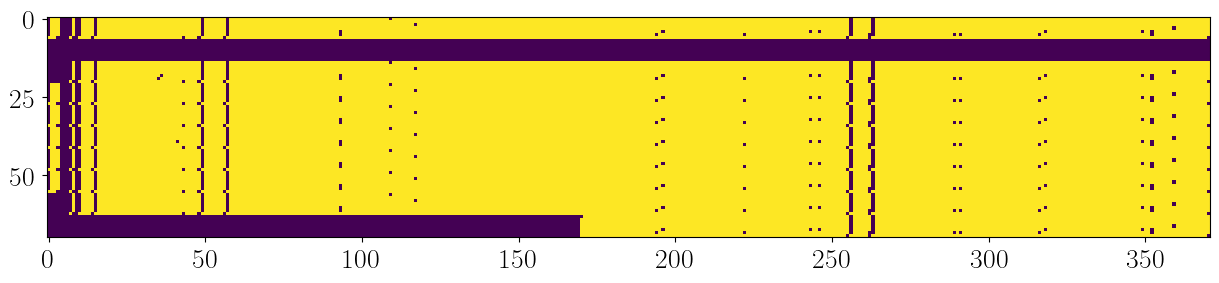

In [21]:
plt.figure(figsize=(15,10))
# plt.imshow(mask_matrix[20:23,45:50], cmap='viridis')
plt.imshow(mask_matrix, cmap='viridis')
plt.show()

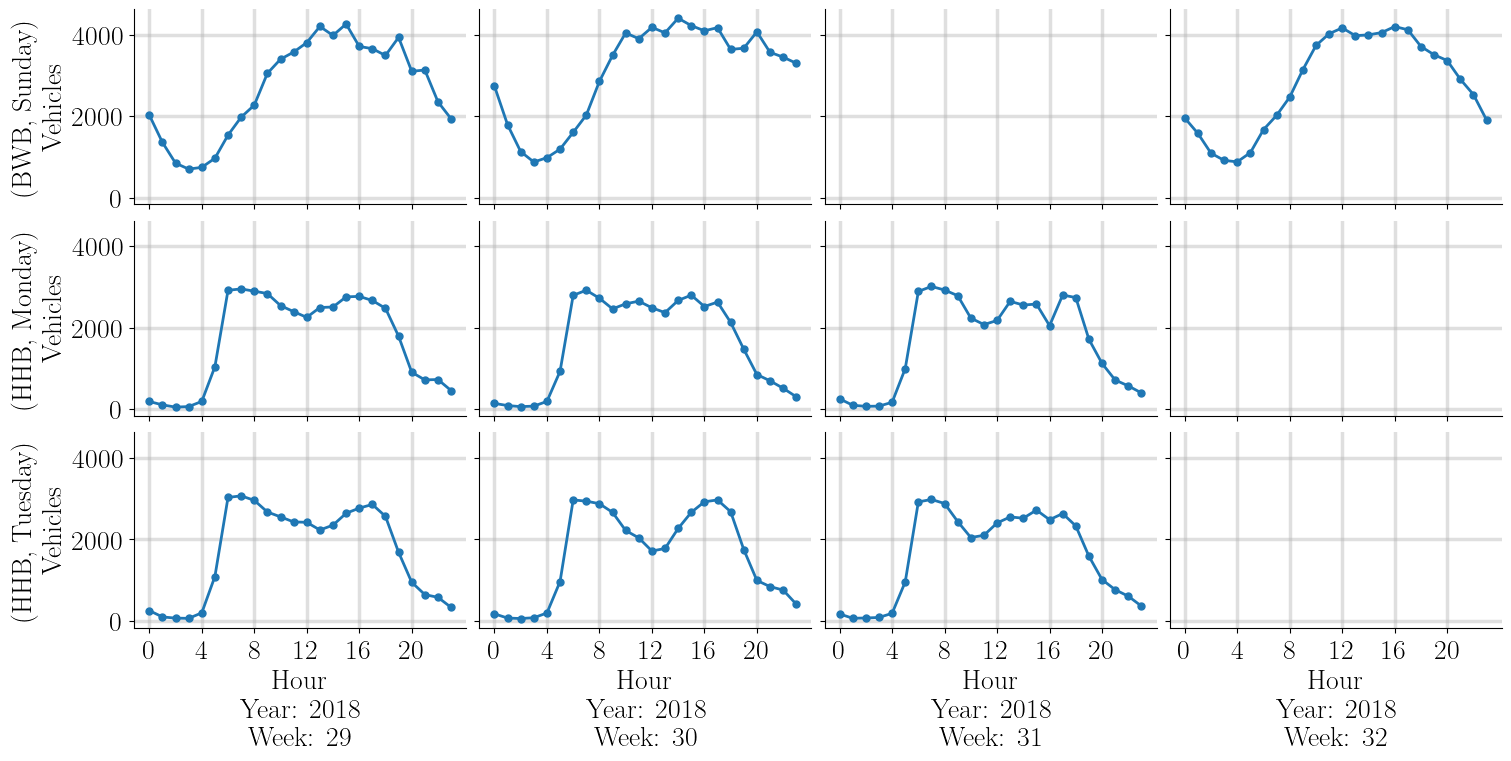

In [45]:
import seaborn as sns

label_size = 20
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = label_size
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = label_size
mpl.rcParams['figure.labelsize'] = label_size
pylab.rcParams['xtick.major.pad']=5
pylab.rcParams['ytick.major.pad']=5

fig, axes = plt.subplots(3, 4, figsize=(15, 7.5), sharey=True, sharex='col', layout="compressed")
min_x = np.inf
max_x = -np.inf
skip = set([(0,0), (2,4), (1,5), (2,2)])
min_xs = {i: np.inf for i in range(6)}
max_xs = {i: -np.inf for i in range(6)}
start_i = 20
start_j = 46
days_of_the_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in range(3):
    for j in range(4):
        if i == 2:
            year = index_to_key[(start_i + i, start_j + j)][1][1]
            week = index_to_key[(start_i + i, start_j + j)][1][0]
            axes[i,j].set_xlabel(f'Hour\nYear: {year}\nWeek: {week}')
            axes[i,j].set_xticks(range(0, 24, 4))
        axes[i,j].spines['top'].set_visible(False)
        axes[i,j].spines['right'].set_visible(False)
        axes[i,j].grid(True, alpha=0.4)
        
        if mask_matrix[start_i + i, start_j + j] == 0:
            continue
        data = data_dict[index_to_key[(start_i + i, start_j + j)]].values.flatten()
        axes[i,j].plot(range(24), data, '.-', linewidth=2, markersize=10)
        min_xs[j] = min(min_xs[j], np.min(data))
        max_xs[j] = max(max_xs[j], np.max(data))
        
    day_of_week = days_of_the_week[rows[start_i+i][1] - 1]
    plaza_name = plaza_ids_to_acronyms[rows[start_i+i][0]]
    axes[i,0].set_ylabel(f'({plaza_name}, {day_of_week})\nVehicles')
# fig.supylabel('Number of Vehicles')
# fig.supxlabel('Hour')
plt.savefig('figures/mta_figures/traffic_data.pdf', bbox_inches='tight')
plt.show()

In [64]:
from fancyimpute import KNN

# find rows that have no observations
rows_no_obs = np.where(np.sum(mask_matrix, axis=1) == 0)[0]
print(rows_no_obs)

# find cols that have no observations
cols_no_obs = np.where(np.sum(mask_matrix, axis=0) == 0)[0]
print(cols_no_obs)

total_matrix_filled = KNN(k=5).fit_transform(total_matrix)
total_matrix_filled[total_matrix_filled == 0] = np.nan
total_matrix_filled

[ 7  8  9 10 11 12 13]
[4 5 6 9]
Imputing row 1/70 with 13 missing, elapsed time: 0.004
[KNN] Warning: 2849/25970 still missing after imputation, replacing with 0


array([[111493.41110032, 132025.        , 139499.        , ...,
        148323.        , 147971.        , 143581.        ],
       [111842.57923409, 151026.        , 146965.        , ...,
        145755.        , 149505.        , 139392.        ],
       [108513.15390521, 139253.        , 145605.        , ...,
        149781.        , 148256.        , 146085.        ],
       ...,
       [107473.31355508, 140676.85937193, 146037.11905097, ...,
        118792.        , 116231.        , 106781.        ],
       [ 98629.65972918, 140957.62060689, 146238.4415847 , ...,
        108031.        , 107016.        , 112980.        ],
       [ 95660.2561897 , 140566.40989842, 146000.06652592, ...,
        108202.        , 106525.        , 110183.67630053]])

In [59]:
raw_results = dict()

# random.seed(0)
num_random = 100
observed_keys = [k for k,v in data_dict.items() if v is not None]
random_keys = random.sample(observed_keys, num_random) # sample without replacement

for i, key in enumerate(random_keys):
    try:
        print(f'Key: {key}, {i}/{num_random}')
        # Test Wasserstein
        dist_threshold = optimize_dist_threshold(key, ppf_dict, pairwise_dists, num_tests=10)
        wasserstein_est = np.array(get_estimate_discrete_dist(key, ppf_dict, pairwise_dists, dist_threshold))
    
        # Test Normalized Euclidean
        dist_threshold = optimize_dist_threshold_euclidean(key, normalized_dict, normalized_euclidean_dists, num_tests=10)
        neighbors = get_neighbors(key, normalized_dict, normalized_euclidean_dists, dist_threshold)
        euclidean_est = get_euclidean_avg(key, normalized_dict, neighbors)
        
        # Test XGBoost
        # refit xgboost model without the key's data
        X = pd.get_dummies(inbound[categorical_vars + numerical_vars], columns=categorical_vars)
        X = X[~((inbound['Plaza ID'] == key[0][0]) & (inbound['Day of Week'] == key[0][1]) & (inbound['Week'] == key[1][0]) & (inbound['Year'] == key[1][1]))]
        y = inbound['Total Vehicles'][~((inbound['Plaza ID'] == key[0][0]) & (inbound['Day of Week'] == key[0][1]) & (inbound['Week'] == key[1][0]) & (inbound['Year'] == key[1][1]))]

        model = XGBRegressor(n_estimators=50, max_depth=10, n_jobs=-1)
        model.fit(X, y)
        plaza_id, weekday = key[0]
        week_number, year = key[1]
        new_data = pd.DataFrame.from_dict({"Hour": list(range(24)), 
                                           "Day of Week": [weekday] * 24, 
                                           "Week": [week_number] * 24, 
                                           "Year": [year] * 24, 
                                           "Plaza ID": [plaza_id] * 24})
        # Convert to same format as original features
        new_data = pd.get_dummies(new_data, columns=["Plaza ID"]).reindex(columns = X.columns, fill_value=False)
        xgboost_pred = model.predict(new_data)
        
        raw_results[key] = {
            'wasserstein': wasserstein_est,
            'normalized_euclidean': euclidean_est,
            'xgboost': xgboost_pred
        }
    except Exception as e:
        continue

Key: ((26, 7), (48, 2022)), 0/100
100%|██████████| 50/50 [00:03<00:00, 13.95trial/s, best loss: 0.0006410803059075313]
Key: ((27, 7), (51, 2020)), 1/100
100%|██████████| 50/50 [00:03<00:00, 14.12trial/s, best loss=?]
Key: ((30, 2), (5, 2024)), 2/100
100%|██████████| 50/50 [00:02<00:00, 21.21trial/s, best loss: 0.00010265677272131894]
Key: ((24, 7), (11, 2020)), 3/100
100%|██████████| 50/50 [00:03<00:00, 13.94trial/s, best loss: 0.0007392910880796478]
Key: ((24, 6), (16, 2018)), 4/100
100%|██████████| 50/50 [00:03<00:00, 14.04trial/s, best loss: 0.0004912985543813135]
Key: ((21, 1), (52, 2017)), 5/100
100%|██████████| 50/50 [00:03<00:00, 14.13trial/s, best loss: 0.0010603226251656725]
Key: ((30, 7), (42, 2021)), 6/100
100%|██████████| 50/50 [00:02<00:00, 21.11trial/s, best loss: 0.00015172674618956134]
Key: ((23, 7), (41, 2023)), 7/100
100%|██████████| 50/50 [00:03<00:00, 13.94trial/s, best loss=?]
Key: ((28, 7), (48, 2018)), 8/100
100%|██████████| 50/50 [00:03<00:00, 14.04trial/s, best

In [713]:
k = ((29, 2),(9,2020))

total_matrix_copy = total_matrix.copy()
i,j = key_to_index[k]
total_matrix_copy[i,j] = np.nan # remove the observed data
total_matrix_copy_filled = KNN(k=5,verbose=False).fit_transform(total_matrix_copy)
total_matrix_copy_filled[total_matrix_copy_filled == 0] = np.nan

est_total = total_matrix_copy_filled[i,j]

plt.plot(range(24),raw_results[k]['wasserstein'], label='Wasserstein')
plt.plot(range(24),raw_results[k]['normalized_euclidean'], label='Euclidean')
plt.plot(range(24),raw_results[k]['xgboost'] / np.sum(raw_results[k]['xgboost']), label='XGBoost')
plt.plot(range(24),data_dict[k].values / np.sum(data_dict[k].values.flatten()), label='Observed', linestyle='--', color='black')
plt.legend()
plt.show()

KeyError: ((29, 2), (9, 2020))

In [60]:
len(raw_results)

92

In [61]:
with open('raw_results.pkl', 'wb') as f:
    pickle.dump(raw_results, f)

In [48]:
with open('raw_results.pkl', 'rb') as f:
    raw_results = pickle.load(f)

In [75]:
%matplotlib inline

from torch import NoneType


label_size = 16
mpl.rcParams['lines.markersize'] = 7
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = label_size

mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

std_errors = dict()
mean_errors = dict()
# median_errors = dict()
var_errors = dict()
avg_abs_dist = dict()
max_abs_dist = dict()
wasserstein_dist = dict()

all_errors = [std_errors, mean_errors, var_errors, avg_abs_dist, max_abs_dist, wasserstein_dist]

def empirical_quantile(data_arr):
    """
    Returns a function handle for the empirical quantile
    function given a 1-d dataset.
    """
    return lambda q, data_arr = data_arr : quantile(data_arr, q, method = 'inverted_cdf')

alpha = 0.05

def calculate_var(values, probabilities, alpha=0.05):
    # Sort the values and probabilities in ascending order by value
    sorted_indices = np.argsort(values)
    values_sorted = np.array(values)[sorted_indices]
    probabilities_sorted = np.array(probabilities)[sorted_indices]
    
    # Accumulate probabilities to find the VaR threshold
    cumulative_probability = 0.0
    for value, prob in zip(values_sorted, probabilities_sorted):
        cumulative_probability += prob
        if cumulative_probability >= alpha:
            return value
    return None

for k, v in tqdm(raw_results.items()):
    if v['wasserstein'] is None or v['normalized_euclidean'] is None or v['wasserstein'].size == 1:
        continue
    total_matrix_copy = total_matrix.copy()
    i,j = key_to_index[k]
    total_matrix_copy[i,j] = np.nan # remove the observed data
    total_matrix_copy_filled = KNN(k=5,verbose=False).fit_transform(total_matrix_copy)
    total_matrix_copy_filled[total_matrix_copy_filled == 0] = np.nan
    
    est_total = total_matrix_copy_filled[i,j]
    
    wasserstein_est = v['wasserstein'] * est_total
    normalized_euclidean_est = v['normalized_euclidean'] * est_total
    xgboost_est = v['xgboost']
    
    if normalized_euclidean_est.shape != (24,) or wasserstein_est.shape != (24,):
        continue
    true_data = data_dict[k].values.flatten()
    true_data_probs = true_data / np.sum(true_data)
    
    for error_dict in all_errors:
        error_dict[k] = {'wasserstein': None, 'euclidean': None, 'xgboost': None}
    
    for name, est in zip(['wasserstein', 'euclidean', 'xgboost'], [wasserstein_est, normalized_euclidean_est, xgboost_est]):
        try:
            est_probs = est / np.sum(est)
            np_24 = np.array(list(range(24)))
            true_mean = np.sum(np_24 * true_data_probs)
            est_mean = np.sum(np_24 * est_probs)
            true_std = np.sqrt(np.sum(true_data_probs * (np_24 - true_mean) ** 2))
            est_std = np.sqrt(np.sum(true_data_probs * (np_24 - est_mean) ** 2))
            true_var = calculate_var(np_24, true_data_probs, alpha=alpha)
            est_var = calculate_var(np_24, est_probs, alpha=alpha)
            
            mean_errors[k][name] = np.abs(true_mean - est_mean)
            std_errors[k][name] = np.abs(true_std - est_std)
            var_errors[k][name] = np.abs(true_var - est_var)
            wasserstein_dist[k][name] = squared_difference_integral(est_probs, list(range(24)), true_data_probs, list(range(24)))
            
            # max_errors[k][name] = np.abs(np.max(true_data) - np.max(est))
            # mean_errors[k][name] = np.abs(np.mean(true_data) - np.mean(est))
            # median_errors[k][name] = np.abs(np.median(true_data) - np.median(est))
            # var_errors[k][name] = np.abs(empirical_quantile(-1 * true_data)(1 - alpha) - empirical_quantile(-1 * est)(1 - alpha))
            # min_errors[k][name] = np.abs(np.min(true_data) - np.min(est))
            avg_abs_dist[k][name] = np.mean(np.abs(true_data - est))
            max_abs_dist[k][name] = np.max(np.abs(true_data - est))
        except Exception as e:
            continue
    
    fig = plt.figure()
    # plt.tight_layout()
    ax = plt.gca()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.4)
    
    # plt.plot(range(24), data_dict[k].values.flatten(), label='Observed', linewidth=2, linestyle='--', color='black')
    # plt.plot(range(24), wasserstein_est, label='DistNN-Wass.', linestyle='-', linewidth=2)
    # plt.plot(range(24), normalized_euclidean_est, label='DistNN-Eucl.', linestyle='-', linewidth=2)
    # plt.plot(range(24), v['xgboost'], label='XGBoost', linestyle='-', linewidth=2)
    # plt.xlabel('Hour of the Day')
    # plt.ylabel('Number of Vehicles')
    
    # plt.savefig(f'figures/mta_figures/{k}.pdf', bbox_inches="tight")
    plt.step(np.cumsum(true_data_probs), list(range(24)), label='Observed', where='post', linestyle='--', color='black')
    plt.step(np.cumsum(v['wasserstein']), list(range(24)), label='DistNN-Wass.', where='post', linestyle='-', linewidth=2)
    plt.step(np.cumsum(v['normalized_euclidean']), list(range(24)), label='DistNN-Eucl.', where='post', linestyle='-', linewidth=2)
    plt.step(np.cumsum(v['xgboost'] / np.sum(v['xgboost'])), list(range(24)), label='XGBoost', where='post', linestyle='-', linewidth=2)
    plt.ylabel('Hour of the Day')
    plt.xlabel('Probability')
    plt.legend()
    plt.savefig(f'figures/mta_figures/quantile_funcs/{k}.pdf', bbox_inches="tight")
    plt.close(fig)

100%|██████████| 92/92 [00:07<00:00, 11.70it/s]


In [ ]:
np.cumsum()

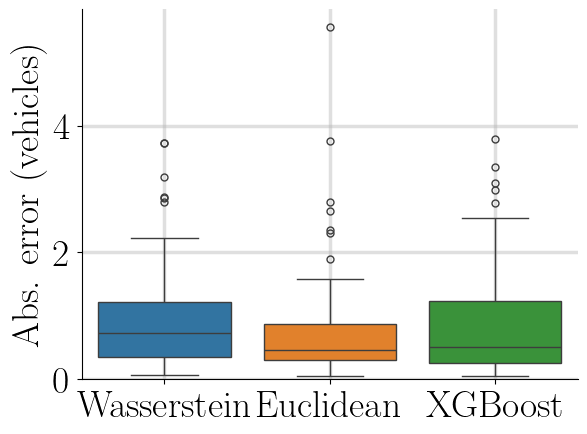

In [69]:
import seaborn as sns

label_size = 27
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = label_size
pylab.rcParams['xtick.major.pad']=5
pylab.rcParams['ytick.major.pad']=5

def boxplot_errors(error_dict, filename: str = None, max_y = None):
    errors_total = np.array([
        [v['wasserstein'] for v in error_dict.values()],
        [v['euclidean'] for v in error_dict.values()],
        [v['xgboost'] for v in error_dict.values()]
    ]).T
    labels = ["Wasserstein", "Euclidean", 'XGBoost']
    ax = sns.boxplot(errors_total)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.4)

    if max_y is not None:
        plt.ylim([0,max_y])
    ax.set_xticklabels(labels)
    ax.set_ylim(bottom=0)
    plt.ylabel("Abs. error (vehicles)")
    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()

base_path = 'figures/mta_figures/'
boxplot_errors(wasserstein_dist, base_path + 'wasserstein_dist.pdf')
# boxplot_errors(max_abs_dist, base_path + 'max_abs_dist.pdf', 4000)
# boxplot_errors(std_errors, base_path + 'std_dist.pdf', 0.1)
# # boxplot_errors(max_errors, base_path + 'max_dist.pdf', 1500)
# boxplot_errors(mean_errors, base_path + 'mean_dist.pdf', 1)
# # boxplot_errors(median_errors, base_path + 'median_dist.pdf', 1000)
# boxplot_errors(var_errors, base_path + 'var_dist.pdf', 4)
# boxplot_errors(avg_abs_dist, base_path + 'avg_dist.pdf', 1000)

### EDA

In [400]:
cols = sorted(cols, key=lambda x: (x[1], x[0]))

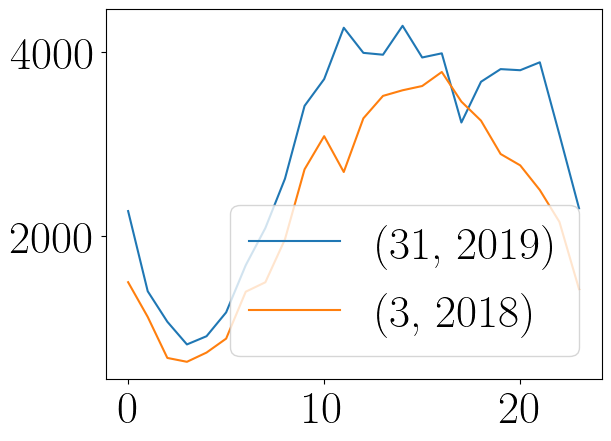

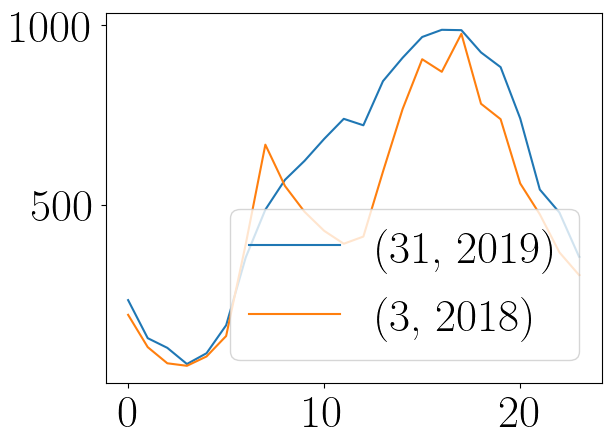

In [428]:
row1 = 3
row2 = 40
col1 = 100
col2 = 20

plt.figure()
plt.plot(list(range(24)),data_dict[(rows[row1], cols[col1])].values.flatten(), label=cols[col1])
plt.plot(list(range(24)),data_dict[(rows[row1], cols[col2])].values.flatten(), label=cols[col2])
plt.legend()
plt.show()

plt.figure()
plt.plot(list(range(24)),data_dict[(rows[row2], cols[col1])].values.flatten(), label=cols[col1])
plt.plot(list(range(24)),data_dict[(rows[row2], cols[col2])].values.flatten(), label=cols[col2])
plt.legend()
plt.show()

<Axes: xlabel='Hour'>

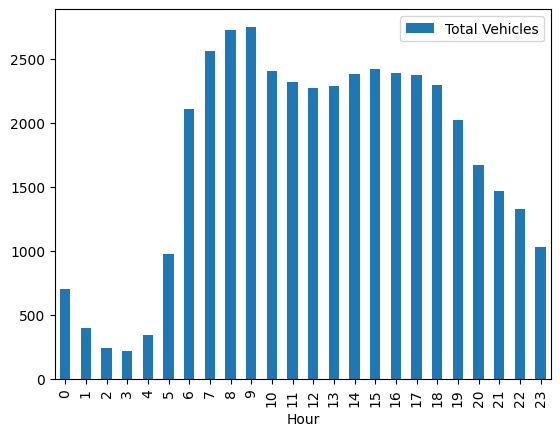

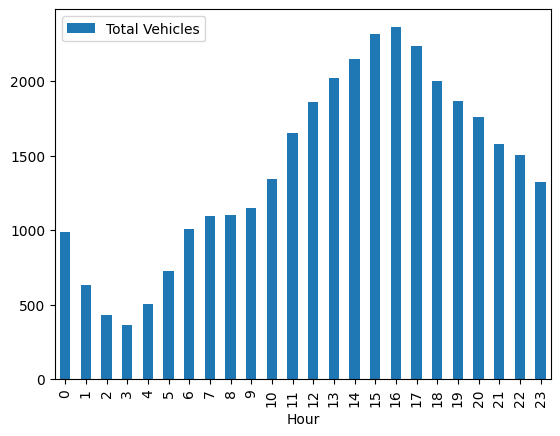

In [ ]:
inbound = mta_data_queens_midtown_tunnel[mta_data_queens_midtown_tunnel['Direction'] == 'I']
outbound = mta_data_queens_midtown_tunnel[mta_data_queens_midtown_tunnel['Direction'] == 'O']

total_vehicles_in = inbound['# Vehicles - E-ZPass'] + inbound['# Vehicles - VToll']
inbound['Total Vehicles'] = total_vehicles_in

total_vehicles_out = outbound['# Vehicles - E-ZPass'] + outbound['# Vehicles - VToll']
outbound['Total Vehicles'] = total_vehicles_out

cols = ['Hour', 'Total Vehicles']

inbound = inbound[cols]
inbound.groupby('Hour').mean().plot(kind='bar')

outbound = outbound[cols]
outbound.groupby('Hour').mean().plot(kind='bar')

<Axes: xlabel='Hour'>

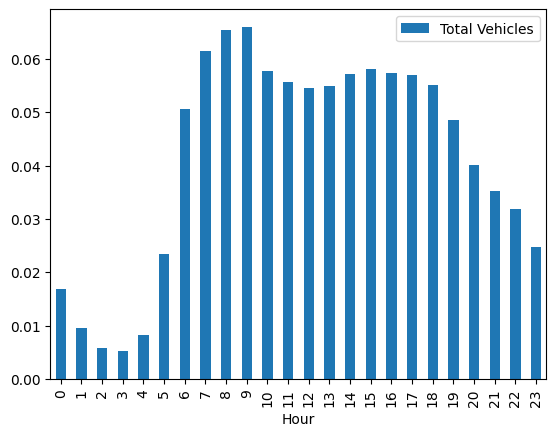

In [ ]:
# We don't want to lose the time series information
# Essentially, we are doing functional matrix completion as opposed to distributional.
# There should not really be much of a difference if we also impute the total number of cars in a matrix cell.

# Let's analyze the wasserstein barycenter between two discrete distributions

inbound_mean = inbound.groupby('Hour').mean()

inbound_mean_scaled = inbound_mean / inbound_mean.sum()
inbound_mean_scaled.plot(kind='bar')

<Axes: xlabel='Hour'>

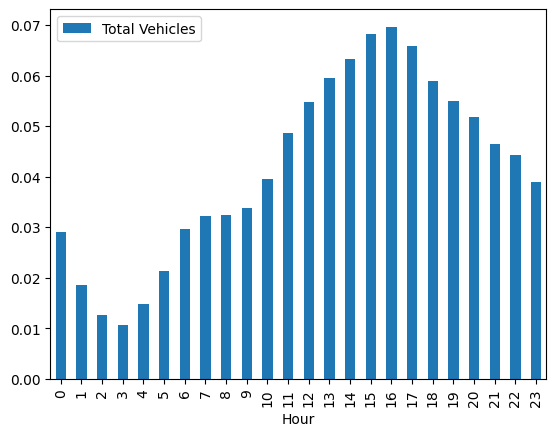

In [ ]:
outbound_mean = outbound.groupby('Hour').mean()

outbound_mean_scaled = outbound_mean / outbound_mean.sum()
outbound_mean_scaled.plot(kind='bar')

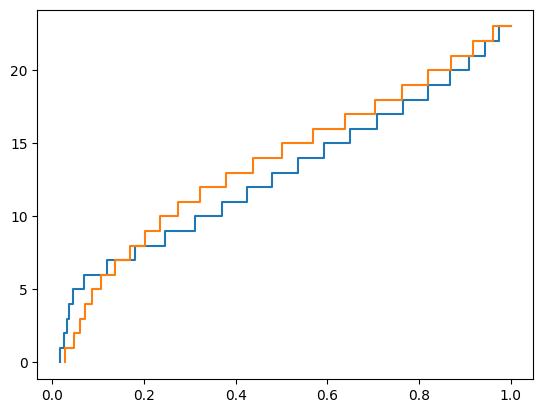

In [ ]:
inbound_mean_scaled_cumsum = inbound_mean_scaled.cumsum()
outbound_mean_scaled_cumsum = outbound_mean_scaled.cumsum()

plt.step(inbound_mean_scaled_cumsum,inbound_mean_scaled_cumsum.index)
plt.step(outbound_mean_scaled_cumsum,outbound_mean_scaled_cumsum.index)

In [ ]:
values = inbound_mean_scaled.index.to_numpy()
cdf = inbound_mean_scaled_cumsum.values.flatten()

In [ ]:
from scipy.integrate import quad
from functools import partial
from numpy import quantile

import warnings
warnings.filterwarnings("ignore")

def wasserstein2(inv_cdf1, inv_cdf2):
    """
    Compute the squared 2-Wasserstein metric.
    """
    # Combine the inner part of the integral into one function
    # Estimate integral via quadrature
    y, _ = quad(lambda x : np.power((inv_cdf1(x) - inv_cdf2(x)), 2), 0, 1)
    return y

In [ ]:
ppf1 = partial(discrete_quantile, inbound_mean_scaled_cumsum.index.to_numpy(), inbound_mean_scaled_cumsum.values.flatten())
ppf2 = partial(discrete_quantile, outbound_mean_scaled_cumsum.index.to_numpy(), outbound_mean_scaled_cumsum.values.flatten())

wasserstein2(ppf1, ppf2)

1.9632668101896897